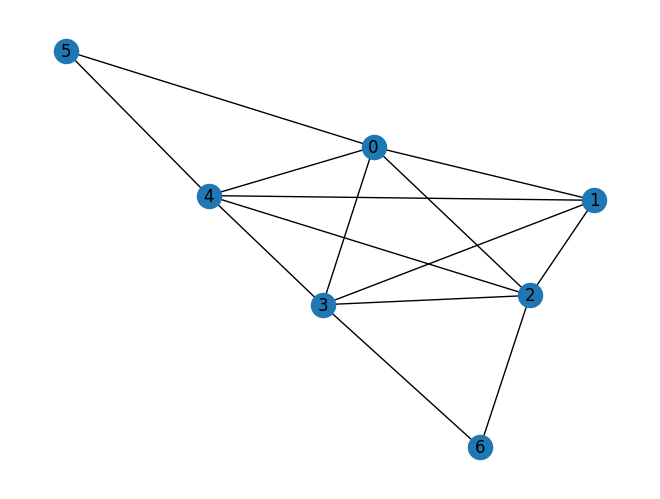

In [278]:
import networkx as nx
from matplotlib import pyplot as plt

class Graph:
    def __init__(self, edges_set):
        self.edges_set = edges_set
        self.node_set = []
        for i in edges_set:
            if (i.start_node not in self.node_set):
                self.node_set.append(i.start_node)
            if (i.end_node not in self.node_set):
                self.node_set.append(i.end_node)

class Edge:
    def __init__(self, start_node, end_node):
        self.start_node = start_node
        self.end_node = end_node

set_edges = [Edge(0, 1), Edge(1, 2), Edge(2, 3), Edge(3, 0), Edge(2, 0), Edge(1, 3), Edge(0, 4), Edge(1, 4), Edge(2, 4), Edge(3, 4), Edge(4, 5), Edge(5, 0), Edge(2, 6), Edge(6, 3)]
# set_edges = [Edge(2, 1), Edge(5, 2), Edge(5, 6), Edge(3, 0), Edge(3, 4), Edge(0, 6), Edge(6, 2), Edge(1, 5), Edge(1, 6)]
# set_edges = [Edge(0, 1), Edge(1, 2), Edge(2, 0), Edge(2, 3), Edge(1, 4), Edge(4, 5), Edge(5, 2), Edge(0, 6), Edge(1, 5), Edge(2, 4), Edge(0, 4), Edge(0, 5)]

G = nx.Graph()

for z in set_edges:
    G.add_edge(str(z.start_node), str(z.end_node))


# edges = [(2,1), (5,2), (5,6), (0,3), (3,4), (0,6), (6,2), (1,5), (1,6)]
# edges = [(0, 1), (1, 2), (2, 0), (2, 3), (1, 4), (4, 5), (5, 2), (0, 6), (1,5),(2,4), (0,4), (0,5)]

# G = nx.Graph(edges)
nx.draw(G, with_labels=True)
plt.show()

In [279]:
# Identifies G¯
graph = Graph(set_edges)

anti_edges = []
for i in range(0, max(graph.node_set)+1):
    for j in range(0, max(graph.node_set)+1):
        hold = True
        for v in graph.edges_set:
            h = [v.start_node, v.end_node]
            if (i in h and j in h):
                hold = False
        if (hold and i > j):
            anti_edges.append(Edge(i, j))

anti_graph = Graph(anti_edges)

In [280]:
import cirq
import numpy as np
import math
from matplotlib import pyplot as plt
import random
from scipy.optimize import minimize

# Defines the list of qubits

num = 7
depth = 4
rep = 1000
qubits = [cirq.GridQubit(0, i) for i in range(0, num)]


# Defines the initialization

def initialization(qubits):
    for i in qubits:
        yield cirq.H.on(i)

In [281]:


# Defines the cost unitary
def cost_unitary(qubits, gamma):
    for i in anti_graph.edges_set:
        yield cirq.ZZPowGate(exponent=-1*gamma/math.pi).on(qubits[i.start_node], qubits[i.end_node])
        yield cirq.Rz(rads=-2*gamma).on(qubits[i.start_node])
        yield cirq.Rz(rads=-2*gamma).on(qubits[i.end_node])

    for i in qubits:
        yield cirq.Rz(rads=2*gamma).on(i)


# Defines the mixer unitary
def mixer_unitary(qubits, alpha):
    for i in range(0, len(qubits)):
        yield cirq.XPowGate(exponent=-1*alpha/math.pi).on(qubits[i])

In [282]:
# Executes the circuit
def create_circuit(params):

    gamma = [params[0], params[2], params[4], params[6]]
    alpha = [params[1], params[3], params[5], params[7]]

    circuit = cirq.Circuit()
    circuit.append(initialization(qubits))
    for i in range(0, depth):
        circuit.append(cost_unitary(qubits, gamma[i]))
        circuit.append(mixer_unitary(qubits, alpha[i]))
    circuit.append(cirq.measure(*qubits, key='x'))
    print(circuit)

    simulator = cirq.Simulator()
    results = simulator.run(circuit, repetitions=rep)
    results = str(results)[2:].split(", ")
    new_res = []
    for i in range(0, rep):
        hold = []
        for j in range(0, num):
            hold.append(int(results[j][i]))
        new_res.append(hold)

    return new_res

In [283]:
# Cost Function
def cost_function(params):

    av = create_circuit(params)
    total_cost = 0
    for i in range(0, len(av)):
        for j in range(0, len(av[i])):
            total_cost += 1-2*av[i][j]
        for j in anti_graph.edges_set:
            total_cost += (-2*av[i][j.start_node] + 1)*(-2*av[i][j.end_node] + 1) - (-2*av[i][j.start_node] + 1) - (-2*av[i][j.end_node] + 1) + 1
    total_cost = float(total_cost)/rep

    print("Cost: "+str(total_cost))

    return total_cost

               ┌────────────────┐               ┌──────────────────┐               ┌──────────────────┐                                                                 ┌────────────────┐               ┌──────────────────┐               ┌──────────────────┐                                                               ┌────────────────┐                ┌───────────────────┐                ┌───────────────────┐                                                                   ┌────────────────┐                ┌───────────────────┐                ┌───────────────────┐
(0, 0): ───H────────────ZZ──────────Rz(1.53π)────Rz(-1.53π)────────────X^(-9/14)─────────────────────────────────────────────────────────────────────────────────────────────────ZZ──────────Rz(1.19π)────Rz(-1.19π)────────────X^-0.36─────────────────────────────────────────────────────────────────────────────────────────────────ZZ──────────Rz(0.974π)────Rz(-0.974π)────────────X^(8/9)─────────────────────────────────────────────

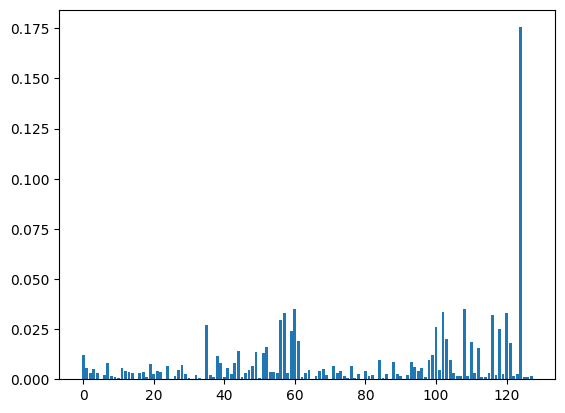

In [284]:
# Defines the optimization method

init =[float(random.randint(-314, 314))/float(100) for i in range(0, 8)]
out = minimize(cost_function, x0=init, method="COBYLA", options={'maxiter':100})
print(out)

optimal_params = out['x']
f = create_circuit(optimal_params)

# Creates visualization of the optimal state

nums = []
freq = []

for i in range(0, len(f)):
    number = 0
    for j in range(0, len(f[i])):
        number += 2**(len(f[i])-j-1)*f[i][j]
    if (number in nums):
        freq[nums.index(number)] = freq[nums.index(number)] + 1
    else:
        nums.append(number)
        freq.append(1)

freq = [s/sum(freq) for s in freq]

print(nums)
print(freq)

x = range(0, 2**num)
y = []
for i in range(0, len(x)):
    if (i in nums):
        y.append(freq[nums.index(i)])
    else:
        y.append(0)

plt.bar(x, y)
plt.show()



In [285]:
def get_highest_probability_bitstring(resultInt):
    max_index = resultInt
    num_wires = G.number_of_nodes()

    bitstring = [0] * num_wires

    for i in range(num_wires):
        bitstring[i] = max_index % 2
        max_index //= 2

    bitstring = bitstring[::-1]
    return bitstring

# Bitstring with the order of the nodes: 0, 1, 2, 3
maxFreq = np.max(freq)
print(maxFreq)
resultInt = nums[freq.index(maxFreq)]
print(resultInt)
highest_prob_bitstring = get_highest_probability_bitstring(resultInt)
print("Int highest probability:", resultInt)
print("Bitstring with highest probability:", highest_prob_bitstring)

0.1755
124
Int highest probability: 124
Bitstring with highest probability: [1, 1, 1, 1, 1, 0, 0]
